<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch04_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jax==0.4.24
!pip install flax==0.7.5
!pip install optax==0.1.7
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.23
    Uninstalling jax-0.4.23:
      Successfully uninstalled jax-0.4.23
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.8.1
    Uninstalling flax-0.8.1:
      Successfully uninstalled flax-0.8.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: optax
    Found existing installation: optax 0.2.1
    Uninstalling optax-0.2.1:
      Successfully uninstalled optax-0.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta

In [2]:
import jax
import flax
import optax


print("JAX Version : {}".format(jax.__version__))
print("FLAX Version : {}".format(flax.__version__))
print("OPTAX Version : {}".format(optax.__version__))

JAX Version : 0.4.24
FLAX Version : 0.7.5
OPTAX Version : 0.1.7


In [3]:
import jax.numpy as jnp
from datasets import load_dataset


def get_datasets():
   datasets = load_dataset("mnist")
   datasets = datasets.with_format("jax")
   datasets = {
       "train": {
           "image": datasets["train"]["image"][...,None].astype(jnp.float32)/255,
           "label": datasets["train"]["label"],
       },
       "test": {
           "image": datasets["test"]["image"][...,None].astype(jnp.float32)/255,
           "label": datasets["test"]["label"],
       },
   }
   return datasets['train'], datasets['test']

In [4]:
train_ds, test_ds = get_datasets()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
from functools import partial
from typing import Any, Callable, Sequence, Tuple
from flax import linen as nn
import jax.numpy as jnp




ModuleDef = Any


In [6]:
class ResNetBlock(nn.Module):
    filters: int
    conv: ModuleDef
    norm: ModuleDef
    act: Callable
    strides: Tuple[int, int] = (1, 1)

    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (1, 1))(x)
        y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3, 3), self.strides)(y)
        y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters * 4, (1, 1))(y)
        y = self.norm(scale_init=nn.initializers.zeros_init())(y)

        if residual.shape != y.shape:
            residual = self.conv(self.filters * 4, (1, 1),
                                 self.strides)(residual)
            residual = self.norm()(residual)

        return self.act(residual + y)

In [7]:
class ResNet(nn.Module):
    stage_sizes: Sequence[int]
    block_cls: ModuleDef
    num_classes: int = 10
    num_filters: int = 64
    dtype: Any = jnp.float32
    act: Callable = nn.relu
    conv: ModuleDef = nn.Conv

    @nn.compact
    def __call__(self, x, train: bool = True):
        conv = partial(self.conv, use_bias=False, dtype=self.dtype)
        norm = partial(nn.BatchNorm,
                       use_running_average=not train,
                       momentum=0.9,
                       epsilon=1e-5,
                       dtype=self.dtype)

        # stage-1
        x = conv(self.num_filters, (7, 7), (2, 2),
                 padding=[(3, 3), (3, 3)])(x)
        x = norm()(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')

        # stage-2,3,4,5
        for i, block_size in enumerate(self.stage_sizes):
            for j in range(block_size):
                strides = (2, 2) if i > 0 and j == 0 else (1, 1)
                x = self.block_cls(self.num_filters * 2 ** i,
                                strides=strides,
                                conv=conv,
                                norm=norm,
                               act=self.act)(x)
        x = jnp.mean(x, axis=(1,2))
        x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
        x = jnp.asarray(x, self.dtype)
        return x



In [8]:
def compute_metrics(logits, labels):
   loss = jnp.mean(optax.softmax_cross_entropy(logits,
                   jax.nn.one_hot(labels, num_classes=10)))
   accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
   metrics = {
       'loss': loss,
       'accuracy': accuracy
   }
   return metrics



In [9]:
from flax.training import train_state

# 모델 초기화
rng = jax.random.PRNGKey(0)
model = partial(ResNet, stage_sizes=[3, 4, 6, 3],
                block_cls=ResNetBlock)
rng, key = jax.random.split(rng)
variables = model().init(key, jnp.ones((1, 28, 28, 1)), train=False)
params = variables['params']
batch_stats = variables['batch_stats']

# optimizer
b1 = 0.9
b2 = 0.999
learning_rate = 0.001
tx = optax.adam(learning_rate=learning_rate, b1=b1, b2=b2)

# TrainState 초기화
class TrainState(train_state.TrainState):
    batch_stats: Any

state = TrainState.create(
    apply_fn=model().apply,
    params=params,
    batch_stats=batch_stats,
    tx=tx,
)

In [10]:
@jax.jit
def train_step(state, batch):
   def loss_fn(params):
       logits, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                               x=batch['image'], train=True, mutable=['batch_stats'])
       loss = jnp.mean(optax.softmax_cross_entropy(
           logits=logits,
           labels=jax.nn.one_hot(batch['label'], num_classes=10))
       )
       return loss, (logits, updates)


   grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
   (_, (logits, updates)), grads = grad_fn(state.params)
   state = state.apply_gradients(grads=grads)
   state = state.replace(batch_stats=updates['batch_stats'])


   metrics = compute_metrics(logits, batch['label'])
   return state, metrics


@jax.jit
def eval_step(state, batch):
   logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                           x=batch['image'], train=False)
   return compute_metrics(logits, batch['label'])


In [11]:
def train_loop(state, train_ds, batch_size, epoch, rng):
   train_ds_size = train_ds['image'].shape[0]
   steps_per_epoch = train_ds_size // batch_size


   perms = jax.random.permutation(rng, train_ds_size)
   perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
   perms = perms.reshape((steps_per_epoch, batch_size))


   batch_metrics = []
   for perm in perms:
       batch = {k: v[perm, ...] for k, v in train_ds.items()}
       state, metrics = train_step(state, batch)
       batch_metrics.append(metrics)


   training_batch_metrics = jax.device_get(batch_metrics)
   training_epoch_metrics = {
       k: sum([metrics[k] for metrics in training_batch_metrics])/steps_per_epoch
       for k in training_batch_metrics[0]}


   print('EPOCH: %d\nTraining loss: %.4f, accuracy: %.2f' % (epoch, training_epoch_metrics['loss'], training_epoch_metrics['accuracy'] * 100))
   return state


def eval_loop(state, test_ds, batch_size):
   eval_ds_size = test_ds['image'].shape[0]
   steps_per_epoch = eval_ds_size // batch_size


   batch_metrics = []
   for i in range(steps_per_epoch):
       batch = {k: v[i*batch_size:(i+1)*batch_size, ...] for k, v in test_ds.items()}
       metrics = eval_step(state, batch)
       batch_metrics.append(metrics)


   eval_batch_metrics = jax.device_get(batch_metrics)
   eval_batch_metrics = {
       k: sum([metrics[k] for metrics in eval_batch_metrics])/steps_per_epoch
       for k in eval_batch_metrics[0]}


   print('    Eval loss: %.4f, accuracy: %.2f' % (eval_batch_metrics['loss'], eval_batch_metrics['accuracy'] * 100))


In [12]:
%%time


train_epoch = 5
batch_size = 64
eval_batch_size = 100


for epoch in range(train_epoch):
   rng, key = jax.random.split(rng)
   state = train_loop(state, train_ds, batch_size, epoch, rng)
   eval_loop(state, test_ds, eval_batch_size)

@jax.jit
def eval_accuracy(state, batch, labels):
   logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, x=batch, train=False)
   return jnp.mean(jnp.argmax(logits, -1) == labels)


print('accuracy: %.2f' % (eval_accuracy(state, test_ds['image'], test_ds['label']) * 100))


EPOCH: 0
Training loss: 0.1841, accuracy: 94.85
    Eval loss: 0.0731, accuracy: 97.65
EPOCH: 1
Training loss: 0.0594, accuracy: 98.21
    Eval loss: 0.0484, accuracy: 98.55
EPOCH: 2
Training loss: 0.0399, accuracy: 98.75
    Eval loss: 0.0573, accuracy: 98.29
EPOCH: 3
Training loss: 0.0372, accuracy: 98.89
    Eval loss: 0.0435, accuracy: 98.84
EPOCH: 4
Training loss: 0.0318, accuracy: 99.00
    Eval loss: 0.0425, accuracy: 98.85
accuracy: 98.85
CPU times: user 2min 40s, sys: 34.2 s, total: 3min 14s
Wall time: 3min 12s


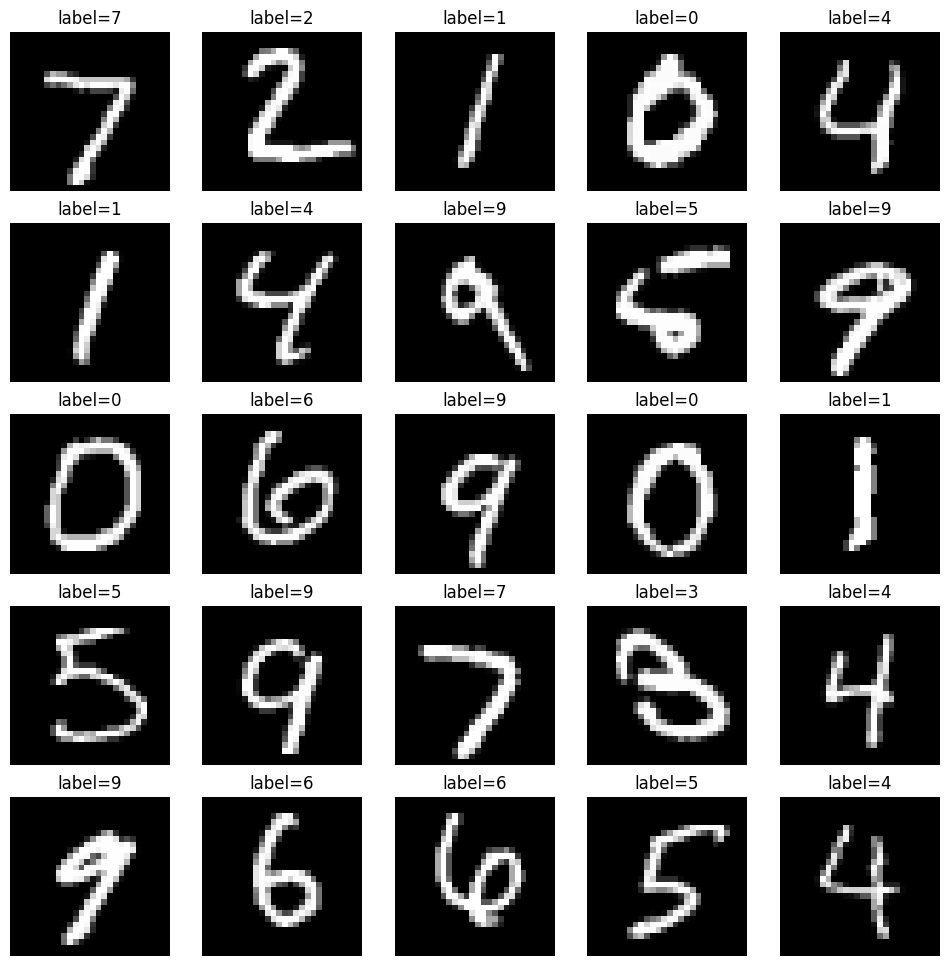

In [13]:
@jax.jit
def pred_step(state, batch):
   logits = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, x=batch, train=False)
   return logits.argmax(axis=1)


pred = pred_step(state, test_ds['image'][:25])


import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
   ax.imshow(test_ds['image'][i], cmap='gray')
   ax.set_title(f"label={pred[i]}")
   ax.axis('off')